In [1]:
from training import llm
from transformers import (
    LlamaTokenizerFast,
    TrainingArguments,
    Trainer,
    LlamaForSequenceClassification,
    BitsAndBytesConfig,
    AutoTokenizer,
    pipeline,
    AutoModelForSequenceClassification,
)
import numpy as np
import pandas as pd
import sklearn.metrics
import bitsandbytes as bnb
import datasets
import evaluate
import torch
from huggingface_hub import login
import os
import random
import spacy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import json

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mac9908/.cache/huggingface/token
Login successful


In [4]:
l = llm.LLMTrain(data='./data/infrastructure.csv',
            config='./training/llm-config.json',
            mask=False,
            base_model='mistralai/Mistral-7B-v0.1',
            exp='Mistral_nomask')

In [5]:
l.train()

Your GPU supports bfloat16: accelerate training with bf16=True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-v0.1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing dataset


Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mac9908 (urban-data-science). Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,3.746500,1.176668,0.816784
2,0.800800,1.275434,0.920727
3,0.048500,2.361312,0.916530
4,0.000300,2.537221,0.917747
5,0.000000,2.427359,0.917747


The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GPT2ForSequenceClassification',

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

/home/mac9908/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Precision Score: 0.6538461538461539
Accuracy Score: 0.9224030037546934
Balanced Accuracy Score: 0.7775775465605532
F1: 0.6219512195121951
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       713
         1.0       0.65      0.59      0.62        86

    accuracy                           0.92       799
   macro avg       0.80      0.78      0.79       799
weighted avg       0.92      0.92      0.92       799



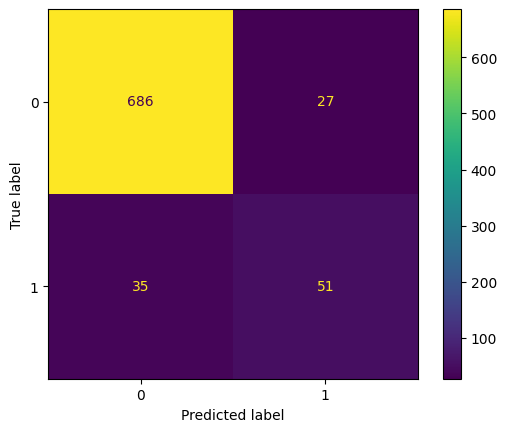

,Unnamed: 0,id,comment,label,labels,predict
0,2015,UgzURxNi_C77Tai4UJN4AaABAg,I remember living in Winooski VT and crossing ...,1.0,1,0
1,1600,UgzPANj-taFusF56yS94AaABAg,"Dear Mr. Buttigieg, My neighborhood is being o...",0.0,0,0
2,218,UgxN7CIAOko_85UbEsB4AaABAg,The scariest Bridge I ever crossed was the Sun...,0.0,0,1
3,1872,UgzwkIaTzXxT0rb7Tjp4AaABAg,"""The eyes of history are on this appointment.""...",0.0,0,0
4,751,Ugx_ul7oRYOC6LhtBQF4AaABAg,All of these government officials should head ...,0.0,0,0
...,...,...,...,...,...,...
794,353,UgzwxkzeSSsBbfyHXkt4AaABAg,I drive over that bridge several times going f...,0.0,0,1
795,337,UgwhH7BgHJjACLc0WBJ4AaABAg,"Saw the ""design"" of the bridge. There was no s...",0.0,0,0
796,2098,jgulsr5,The rattling subway train from 1960s-70s that ...,1.0,1,0
797,668,UgxPAfdI6Nawn1k4m714AaABAg,Pete needs to be looking into this! They’ve do...,0.0,0,0


In [6]:
l.do_eval(l.test_data)

In [7]:
pipe = pipeline(task='text-classification',
              model=l.model,
              tokenizer=l.tokenizer,
              padding="max_length",
              truncation=True,
              max_length=512)
def eval_variance(data, pipe):
    label2id = {"NEGATIVE": 0, "POSITIVE": 1, 'LABEL_0': 0, 'LABEL_1': 1}
    def predict(x):
        x['predict'] = pipe(x['comment'])[0]['label']
        return x
    res = data.map(predict)
    res = res.to_pandas()
    print(res['predict'])
    res['predict'] = res['predict'].map(label2id)
    rep = sklearn.metrics.classification_report(res['label'], res['predict'], output_dict=True)
    precision, recall, f1, accuracy = rep['macro avg']['precision'], rep['macro avg']['recall'], rep['macro avg']['f1-score'], rep['accuracy']
    return precision, recall, f1, accuracy

mp, mr, mf, ma = [],[],[], []
for i in range(5):
  c = l.test_data.train_test_split(test_size=0.3, seed=i)
  precision, recall, f1, accuracy = eval_variance(c['train'], pipe)
  mp.append(precision)
  mr.append(recall)
  mf.append(f1)
  ma.append(accuracy)
llama2_nomask_res = pd.DataFrame.from_dict({
    'precision': [f'{np.mean(mp)}+-{np.var(mp)}'], 
    'recall': [f'{np.mean(mr)}+-{np.var(mr)}'], 
    'f1': [f'{np.mean(mf)}+-{np.var(mf)}'], 
    'accuracy': [f'{np.mean(ma)}+-{np.var(ma)}']})
llama2_nomask_res

The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GPT2ForSequenceClassification',

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

/home/mac9908/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


0      LABEL_0
1      LABEL_0
2      LABEL_0
3      LABEL_0
4      LABEL_0
        ...   
554    LABEL_1
555    LABEL_0
556    LABEL_0
557    LABEL_0
558    LABEL_0
Name: predict, Length: 559, dtype: object


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

/home/mac9908/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


0      LABEL_0
1      LABEL_0
2      LABEL_0
3      LABEL_0
4      LABEL_0
        ...   
554    LABEL_0
555    LABEL_1
556    LABEL_0
557    LABEL_0
558    LABEL_0
Name: predict, Length: 559, dtype: object


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

/home/mac9908/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


0      LABEL_0
1      LABEL_0
2      LABEL_0
3      LABEL_0
4      LABEL_0
        ...   
554    LABEL_0
555    LABEL_1
556    LABEL_0
557    LABEL_0
558    LABEL_1
Name: predict, Length: 559, dtype: object


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

/home/mac9908/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


0      LABEL_0
1      LABEL_0
2      LABEL_0
3      LABEL_0
4      LABEL_0
        ...   
554    LABEL_0
555    LABEL_1
556    LABEL_0
557    LABEL_0
558    LABEL_1
Name: predict, Length: 559, dtype: object


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

/home/mac9908/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


0      LABEL_1
1      LABEL_1
2      LABEL_0
3      LABEL_0
4      LABEL_0
        ...   
554    LABEL_1
555    LABEL_1
556    LABEL_0
557    LABEL_0
558    LABEL_0
Name: predict, Length: 559, dtype: object


,precision,recall,f1,accuracy
0,0.789232634330772+-0.0003009199617073047,0.7684825353194238+-0.00013962269453296377,0.7780066426646439+-0.00015998710392791754,0.9180679785330949+-1.0752653761348832e-05


In [8]:
llama2_nomask_res.to_json('Mistral_nomask_res.json')